In [1]:
from bs4 import BeautifulSoup
import urllib2
import re
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [136]:

def request_year(year):
    req = urllib2.Request('https://www.wunderground.com/history/airport/KNYC/'+year+'/01/01/CustomHistory.html?dayend=31&monthend=12&yearend='+year+'&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=')
    page = urllib2.urlopen(req)
    page_text = page.read()
    return page_text

def parse_year(page_text,year):
    soup = BeautifulSoup(page_text)
    table = soup.find("table", attrs={"class":"responsive obs-table daily"})

    # headings = [th.get_text() for th in table.find("tr").find_all("th")]
    # Temp. (°F)	Dew Point (°F)	Humidity (%)	Sea Level Press. (in)	Visibility (mi)	Wind (mph)	Precip. (in)	Events
    headings =['Day','T_high','T_avg','T_low','DP_high','DP_avg','DP_low','H_high','H_avg','H_low','P_high','P_avg',
               'P_low','V_high','V_avg','V_low','W_avg','W_low','W_high','R_sum','event']

    datasets = []
    for row in table.find_all("tr")[1:]:
        dataset = {i:j for i,j in zip(headings, (td.get_text().replace('\n','') for td in row.find_all("td")))}
        datasets.append(dataset)

    return dataset

def to_num(x):
    try:
        return float(x)
    except:
        return np.nan


def make_table(dataset, year):
    df=pd.DataFrame(datasets)
    # remove nan columns
    df=df.dropna(axis=0,how='all')

    # inpute months 
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    df['Month']=df.Day.apply(lambda x: x if x in months else np.nan)
    df.Month=df.Month.fillna(method='ffill')

    # erase lines that don't correspond to a day record
    df=df[df.Day.apply(lambda x: x not in months)]
    df['Year'] = year
    df['Date'] = pd.to_datetime(df.apply(lambda x: str(x.Year) +'/'+(x.Month) +'/'+str(x.Day), axis = 1))
    df.index = df.Date
    col_to_num=['T_high','T_avg','T_low','DP_high','DP_avg','DP_low','H_high','H_avg','H_low','P_high','P_avg',
               'P_low','V_high','V_avg','V_low','W_avg','W_low','W_high','R_sum']
    for i in col_to_num:
        df[i]=df[i].apply(to_num)
    return df

year='2012'
page_text=request_year(year)
dataset=parse_year(page_text,year) 
df=make_table(dataset, year)

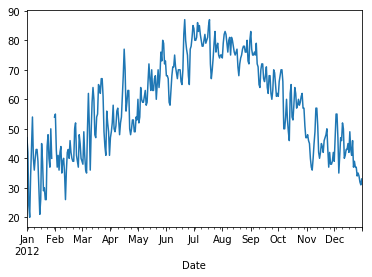

In [144]:
# plot temperature vs time
df.T_avg.plot()

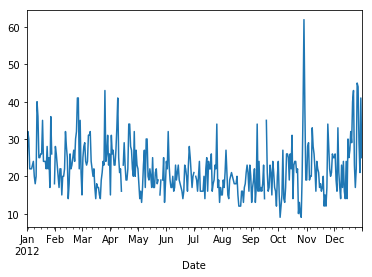

In [145]:
# plot high Wind vs time # you can see Sandy
df.W_high.plot()